# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [147]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [148]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.03
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Iteration 1 -- baseline

In this first iteration, we build the function for feature building and extraction on natural language data.

In [149]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

        
        
    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['myfeature'] =  toxic_data['comment_text'].str.split(' ').str.len() * toxic_data['comment_text'].str.count("\.");
    X_quant_features = toxic_data[["word_count", "punc_count","myfeature"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

### Create training and test sets from function

In [150]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=12345)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

### Fit (and tune) Various Models on both Training and Test dataset

##### MODEL: ordinary least squares

In [151]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print("training set:", ols_performance_train.performance_measures, "\n")

ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print("test set:",ols_performance_test.performance_measures)

training set: {'Pos': 12986, 'Neg': 114670, 'TP': 6454, 'TN': 56308, 'FP': 58362, 'FN': 6532, 'Accuracy': 0.4916494328507865, 'Precision': 0.09957417921500863, 'Recall': 0.49699676574772833, 'desc': 'ols_train'} 

test set: {'Pos': 3239, 'Neg': 28676, 'TP': 1613, 'TN': 14108, 'FP': 14568, 'FN': 1626, 'Accuracy': 0.4925896913676954, 'Precision': 0.09968481552438045, 'Recall': 0.4979932077801791, 'desc': 'ols_test'}


##### MODEL: SVM, linear

In [152]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print("training set:", svm_performance_train.performance_measures, "\n")

svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print("test set:",svm_performance_test.performance_measures)

training set: {'Pos': 12986, 'Neg': 114670, 'TP': 12912, 'TN': 114586, 'FP': 84, 'FN': 74, 'Accuracy': 0.9987622986776963, 'Precision': 0.9935364727608494, 'Recall': 0.9943015555213307, 'desc': 'svm_train'} 

test set: {'Pos': 3239, 'Neg': 28676, 'TP': 2053, 'TN': 27137, 'FP': 1539, 'FN': 1186, 'Accuracy': 0.9146169512768291, 'Precision': 0.5715478841870824, 'Recall': 0.6338376041988268, 'desc': 'svm_test'}


##### MODEL: logistic regression

In [153]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print("training set:", lgs_performance_train.performance_measures, "\n")

lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print("test set:",lgs_performance_test.performance_measures)

training set: {'Pos': 12986, 'Neg': 114670, 'TP': 12919, 'TN': 114612, 'FP': 58, 'FN': 67, 'Accuracy': 0.9990208059158989, 'Precision': 0.995530554057178, 'Recall': 0.9948405975666101, 'desc': 'lgs_train'} 

test set: {'Pos': 3239, 'Neg': 28676, 'TP': 2068, 'TN': 27141, 'FP': 1535, 'FN': 1171, 'Accuracy': 0.9152122826257246, 'Precision': 0.5739661393283375, 'Recall': 0.6384686631676443, 'desc': 'lgs_test'}


##### MODEL: Naive Bayes

In [154]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print("training set:", nbs_performance_train.performance_measures, "\n")

nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print("test set:",nbs_performance_test.performance_measures)

training set: {'Pos': 12986, 'Neg': 114670, 'TP': 12721, 'TN': 103348, 'FP': 11322, 'FN': 265, 'Accuracy': 0.9092326251801717, 'Precision': 0.529093707108098, 'Recall': 0.9795934082858463, 'desc': 'nbs_train'} 

test set: {'Pos': 3239, 'Neg': 28676, 'TP': 2097, 'TN': 23637, 'FP': 5039, 'FN': 1142, 'Accuracy': 0.8063293122356259, 'Precision': 0.2938621076233184, 'Recall': 0.6474220438406916, 'desc': 'nbs_test'}


##### MODEL: Perceptron

In [155]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print("training set:", prc_performance_train.performance_measures, "\n")

prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print("test set:",prc_performance_test.performance_measures)

training set: {'Pos': 12986, 'Neg': 114670, 'TP': 12867, 'TN': 114558, 'FP': 112, 'FN': 119, 'Accuracy': 0.9981904493325813, 'Precision': 0.9913706757069112, 'Recall': 0.9908362852302479, 'desc': 'prc_train'} 

test set: {'Pos': 3239, 'Neg': 28676, 'TP': 2055, 'TN': 27211, 'FP': 1465, 'FN': 1184, 'Accuracy': 0.9169982766724111, 'Precision': 0.5838068181818182, 'Recall': 0.6344550787280024, 'desc': 'prc_test'}


##### MODEL: Ridge Regression Classifier

In [156]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print("training set:", rdg_performance_train.performance_measures, "\n")

rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print("test set:",rdg_performance_test.performance_measures)

training set: {'Pos': 12986, 'Neg': 114670, 'TP': 11748, 'TN': 114488, 'FP': 182, 'FN': 1238, 'Accuracy': 0.9888763552046124, 'Precision': 0.9847443419949706, 'Recall': 0.9046665639919914, 'desc': 'rdg_train'} 

test set: {'Pos': 3239, 'Neg': 28676, 'TP': 1872, 'TN': 26589, 'FP': 2087, 'FN': 1367, 'Accuracy': 0.8917750274165753, 'Precision': 0.47284667845415507, 'Recall': 0.5779561593084285, 'desc': 'rdg_test'}


##### MODEL: Random Forest Classifier

In [157]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth = 3)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train).astype(np.int), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print("training set:",rdf_performance_train.performance_measures, "\n")

rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print("test set:",rdf_performance_test.performance_measures)

/Users/jungang/Documents/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


training set: {'Pos': 12986, 'Neg': 114670, 'TP': 0, 'TN': 114670, 'FP': 0, 'FN': 12986, 'Accuracy': 0.8982734849909131, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'} 

test set: {'Pos': 3239, 'Neg': 28676, 'TP': 0, 'TN': 28676, 'FP': 0, 'FN': 3239, 'Accuracy': 0.8985116716277612, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


/Users/jungang/Documents/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

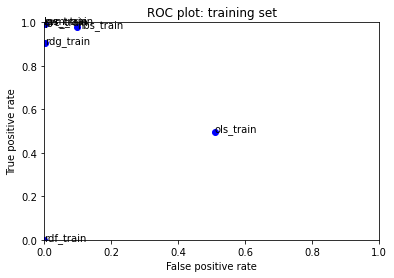

In [158]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

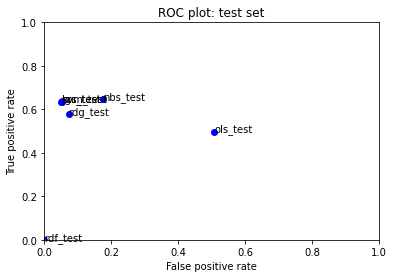

In [159]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# Iteration 2 -- text tidy

In this iteration, I focus on the text processing method. In some situations that text is very dirty, we need to reduce the negative influence that the dirty data lead to. In this dataset, there are a lot of situations we need to pay attention to: the difference of upper and lower cases, common words/ punctuation removal.

After tidy the data, I use the same encoding method as the first iteration and also same models to check the improvement of data preprocessing.

### Text Processing: lowcasing, common word removal

In [160]:

# tidy the original text data by several rules
def words_processing(fn, my_random_seed, test=False):
    # read data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # lowcasing
    toxic_data.comment_text = toxic_data.comment_text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    print("lowcasing complete")
    
    # remove punctuaton
    toxic_data.comment_text = toxic_data.comment_text.str.replace("[^\w\s]", "")
    print("punctuation removal complete")
    
    # remove common words
    word_freq = list(pd.Series(" ".join(toxic_data.comment_text).split()).value_counts()[:20].index)
    toxic_data.comment_text = toxic_data.comment_text.apply(lambda x: " ".join(x for x in x.split() if x not in word_freq))
    print("common words removal complete")

    
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations2.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations2[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations2.append(transformer)
    else:
        X_tfidf = fitted_transformations2[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['myfeature'] =  toxic_data['comment_text'].str.split(' ').str.len() * toxic_data['comment_text'].str.count("\.");
    X_quant_features = toxic_data[["word_count", "punc_count","myfeature"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations2.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations2[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

#s = words_processing(fn='toxiccomments_train.csv', my_random_seed=100)
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations2 = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train2, X_test2, y_train2, y_test2, X_raw_train2, X_raw_test2 = words_processing(fn='toxiccomments_train.csv', my_random_seed=12345)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations2))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

### Model and Assessing

Here I run all models except random forest in the first iterations and name them xxx2 as the distinction to the models in the first iteration.

##### MODEL: ordinary least squares

In [161]:
from sklearn import linear_model
ols2 = linear_model.SGDClassifier(loss="squared_loss")
ols2.fit(X_train2, y_train2)

ols_performance_train2 = BinaryClassificationPerformance(ols2.predict(X_train2), y_train2, 'ols_train2')
ols_performance_train2.compute_measures()
print("training set:", ols_performance_train2.performance_measures, "\n")

ols_performance_test2 = BinaryClassificationPerformance(ols2.predict(X_test2), y_test2, 'ols_test2')
ols_performance_test2.compute_measures()
print("test set:",ols_performance_test2.performance_measures)

training set: {'Pos': 12986, 'Neg': 114670, 'TP': 6653, 'TN': 56060, 'FP': 58610, 'FN': 6333, 'Accuracy': 0.4912655887698189, 'Precision': 0.10194137566461854, 'Recall': 0.5123209610349607, 'desc': 'ols_train2'} 

test set: {'Pos': 3239, 'Neg': 28676, 'TP': 1680, 'TN': 13891, 'FP': 14785, 'FN': 1559, 'Accuracy': 0.4878897070343099, 'Precision': 0.10203461888855148, 'Recall': 0.5186786045075641, 'desc': 'ols_test2'}


##### MODEL: SVM, linear

In [162]:
from sklearn import linear_model
svm2 = linear_model.SGDClassifier()
svm2.fit(X_train2, y_train2)

svm_performance_train2 = BinaryClassificationPerformance(svm2.predict(X_train2), y_train2, 'svm_train2')
svm_performance_train2.compute_measures()
print("training set:", svm_performance_train2.performance_measures, "\n")

svm_performance_test2 = BinaryClassificationPerformance(svm2.predict(X_test2), y_test2, 'svm_test2')
svm_performance_test2.compute_measures()
print("test set:",svm_performance_test2.performance_measures)

training set: {'Pos': 12986, 'Neg': 114670, 'TP': 12914, 'TN': 114579, 'FP': 91, 'FN': 72, 'Accuracy': 0.9987231309143323, 'Precision': 0.9930026912725874, 'Recall': 0.9944555675342677, 'desc': 'svm_train2'} 

test set: {'Pos': 3239, 'Neg': 28676, 'TP': 2018, 'TN': 27076, 'FP': 1600, 'FN': 1221, 'Accuracy': 0.9116089613034624, 'Precision': 0.5577667219458264, 'Recall': 0.6230317999382525, 'desc': 'svm_test2'}


##### MODEL: logistic regression

In [163]:
from sklearn import linear_model
lgs2 = linear_model.SGDClassifier(loss='log')
lgs2.fit(X_train2, y_train2)

lgs_performance_train2 = BinaryClassificationPerformance(lgs2.predict(X_train2), y_train2, 'lgs_train2')
lgs_performance_train2.compute_measures()
print("training set:", lgs_performance_train2.performance_measures, "\n")

lgs_performance_test2 = BinaryClassificationPerformance(lgs2.predict(X_test2), y_test2, 'lgs_test2')
lgs_performance_test2.compute_measures()
print("test set:",lgs_performance_test2.performance_measures)

training set: {'Pos': 12986, 'Neg': 114670, 'TP': 12911, 'TN': 114625, 'FP': 45, 'FN': 75, 'Accuracy': 0.999059973679263, 'Precision': 0.9965267057733869, 'Recall': 0.9942245495148622, 'desc': 'lgs_train2'} 

test set: {'Pos': 3239, 'Neg': 28676, 'TP': 1998, 'TN': 27004, 'FP': 1672, 'FN': 1241, 'Accuracy': 0.9087263042456525, 'Precision': 0.5444141689373297, 'Recall': 0.6168570546464959, 'desc': 'lgs_test2'}


##### MODEL: Ridge Regression Classifier

In [164]:
from sklearn import linear_model
rdg2 = linear_model.RidgeClassifier()
rdg2.fit(X_train2, y_train2)

rdg_performance_train2 = BinaryClassificationPerformance(rdg2.predict(X_train2), y_train2, 'rdg_train2')
rdg_performance_train2.compute_measures()
print("training set:",rdg_performance_train2.performance_measures, "\n")

rdg_performance_test2 = BinaryClassificationPerformance(rdg2.predict(X_test2), y_test2, 'rdg_test2')
rdg_performance_test2.compute_measures()
print("test set:",rdg_performance_test2.performance_measures)

training set: {'Pos': 12986, 'Neg': 114670, 'TP': 12114, 'TN': 114507, 'FP': 163, 'FN': 872, 'Accuracy': 0.9918922729836436, 'Precision': 0.9867231408324509, 'Recall': 0.9328507623594641, 'desc': 'rdg_train2'} 

test set: {'Pos': 3239, 'Neg': 28676, 'TP': 1881, 'TN': 25516, 'FP': 3160, 'FN': 1358, 'Accuracy': 0.8584364718784271, 'Precision': 0.3731402499504067, 'Recall': 0.580734794689719, 'desc': 'rdg_test2'}


##### MODEL: Perceptron

In [165]:
from sklearn import linear_model
prc2 = linear_model.SGDClassifier(loss='perceptron')
prc2.fit(X_train2, y_train2)

prc_performance_train2 = BinaryClassificationPerformance(prc2.predict(X_train2), y_train2, 'prc_train2')
prc_performance_train2.compute_measures()
print("training set:",prc_performance_train2.performance_measures, "\n")

prc_performance_test2 = BinaryClassificationPerformance(prc2.predict(X_test2), y_test2, 'prc_test2')
prc_performance_test2.compute_measures()
print("test set:",prc_performance_test2.performance_measures)

training set: {'Pos': 12986, 'Neg': 114670, 'TP': 12909, 'TN': 114593, 'FP': 77, 'FN': 77, 'Accuracy': 0.9987936328883875, 'Precision': 0.9940705375019252, 'Recall': 0.9940705375019252, 'desc': 'prc_train2'} 

test set: {'Pos': 3239, 'Neg': 28676, 'TP': 2014, 'TN': 27075, 'FP': 1601, 'FN': 1225, 'Accuracy': 0.9114522951590162, 'Precision': 0.5571230982019364, 'Recall': 0.6217968508799012, 'desc': 'prc_test2'}


Here we can find the improvement is very little. I think this is due to the easy way to tidy the data. Then, I consider to apply different method to do the data cleaning.

# Iteration 3 -- dimension reduction

Since in last iteration, the improvement of the model performance is little, I consider it caused by high dimension problem, that the feature is very sparse in high dimension. So dimension reduction techniques will be considered to cope with this problem. Here I only use SVD to solve it.

In [166]:
from sklearn import decomposition
def words_processing_svd(fn, my_random_seed, test=False):
    # read data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # lowcasing
    toxic_data.comment_text = toxic_data.comment_text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    print("lowcasing complete")
    
    # remove punctuaton
    toxic_data.comment_text = toxic_data.comment_text.str.replace("[^\w\s]", "")
    print("punctuation removal complete")

    # remove common words
    word_freq = list(pd.Series(" ".join(toxic_data.comment_text).split()).value_counts()[:20].index)
    toxic_data.comment_text = toxic_data.comment_text.apply(lambda x: " ".join(x for x in x.split() if x not in word_freq))
    print("common words removal complete")

    
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations3.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations3[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations3.append(transformer)
    else:
        X_tfidf = fitted_transformations3[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['myfeature'] =  toxic_data['comment_text'].str.split(' ').str.len() * toxic_data['comment_text'].str.count("\.");
    X_quant_features = toxic_data[["word_count", "punc_count","myfeature"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations3.append(sc)
        
        svd = decomposition.TruncatedSVD(512)
        X = svd.fit_transform(X)
        fitted_transformations3.append(svd)
        print(X.shape)
        y = toxic_data['any_toxic']
        
        
        
        
    else:
        X = fitted_transformations3[2].transform(X_matrix)
        X = fitted_transformations3[3].transform(X)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)
    

#s = words_processing(fn='toxiccomments_train.csv', my_random_seed=100)
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations3 = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train3, X_test3, y_train3, y_test3, X_raw_train3, X_raw_test3 = words_processing_svd(fn='toxiccomments_train.csv', my_random_seed=100)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations3))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

### Model and Assessing

Here we only try to build the model of svm, ridge regression and perceptron to check the results.

##### MODEL: SVM, linear

In [167]:
from sklearn import linear_model
svm3 = linear_model.SGDClassifier()
svm3.fit(X_train3, y_train3)

svm_performance_train3 = BinaryClassificationPerformance(svm3.predict(X_train3), y_train3, 'svm_train3')
svm_performance_train3.compute_measures()
print("training set:", svm_performance_train3.performance_measures, "\n")

svm_performance_test3 = BinaryClassificationPerformance(svm3.predict(X_test3), y_test3, 'svm_test3')
svm_performance_test3.compute_measures()
print("test set:", svm_performance_test3.performance_measures)

training set: {'Pos': 12937, 'Neg': 114719, 'TP': 2887, 'TN': 111584, 'FP': 3135, 'FN': 10050, 'Accuracy': 0.8967146080090242, 'Precision': 0.47940883427432746, 'Recall': 0.22315838293267373, 'desc': 'svm_train3'} 

test set: {'Pos': 3288, 'Neg': 28627, 'TP': 673, 'TN': 27783, 'FP': 844, 'FN': 2615, 'Accuracy': 0.8916183612721291, 'Precision': 0.4436387607119314, 'Recall': 0.204683698296837, 'desc': 'svm_test3'}


##### MODEL: Ridge Regression Classifier

In [168]:
from sklearn import linear_model
rdg3 = linear_model.RidgeClassifier()
rdg3.fit(X_train3, y_train3)

rdg_performance_train3 = BinaryClassificationPerformance(rdg3.predict(X_train3), y_train3, 'rdg_train3')
rdg_performance_train3.compute_measures()
print("training set:",rdg_performance_train3.performance_measures, "\n")

rdg_performance_test3 = BinaryClassificationPerformance(rdg3.predict(X_test3), y_test3, 'rdg_test3')
rdg_performance_test3.compute_measures()
print("test set:", rdg_performance_test3.performance_measures)

training set: {'Pos': 12937, 'Neg': 114719, 'TP': 45, 'TN': 114636, 'FP': 83, 'FN': 12892, 'Accuracy': 0.8983596540703139, 'Precision': 0.3515625, 'Recall': 0.003478395300301461, 'desc': 'rdg_train3'} 

test set: {'Pos': 3288, 'Neg': 28627, 'TP': 8, 'TN': 28586, 'FP': 41, 'FN': 3280, 'Accuracy': 0.8959423468588438, 'Precision': 0.16326530612244897, 'Recall': 0.0024330900243309003, 'desc': 'rdg_test3'}


##### MODEL: Perceptron

In [169]:
from sklearn import linear_model
prc3 = linear_model.SGDClassifier(loss='perceptron')
prc3.fit(X_train3, y_train3)

prc_performance_train3 = BinaryClassificationPerformance(prc3.predict(X_train3), y_train3, 'prc_train3')
prc_performance_train3.compute_measures()
print("training set:", prc_performance_train3.performance_measures, "\n")

prc_performance_test3 = BinaryClassificationPerformance(prc3.predict(X_test3), y_test3, 'prc_test3')
prc_performance_test3.compute_measures()
print("test set:",prc_performance_test3.performance_measures)

training set: {'Pos': 12937, 'Neg': 114719, 'TP': 4886, 'TN': 105110, 'FP': 9609, 'FN': 8051, 'Accuracy': 0.8616594597982077, 'Precision': 0.3370817523283891, 'Recall': 0.37767643193939865, 'desc': 'prc_train3'} 

test set: {'Pos': 3288, 'Neg': 28627, 'TP': 1181, 'TN': 26143, 'FP': 2484, 'FN': 2107, 'Accuracy': 0.8561491461695128, 'Precision': 0.32223738062755797, 'Recall': 0.35918491484184917, 'desc': 'prc_test3'}


The results show this dimension reduction method is not appropriate for this kind of dataset. So I think about different models to deal with it.

# Iteration 4 -- xgboost

From the results of the third iteration, we may find the results show poor results compared with the first and second iterations. So I think this maybe due to poor model performance. Thus in this iteration, I will use a famous machine learning model: Xgboost.

In [170]:
# Xgboost
# Use the default settings using data in iteration 1

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

xgb_performance_train = BinaryClassificationPerformance(xgb.predict(X_train), y_train, 'xgb_train')
xgb_performance_train.compute_measures()
print("training set:",xgb_performance_train.performance_measures, "\n")

xgb_performance_test = BinaryClassificationPerformance(xgb.predict(X_test), y_test, 'xgb_test')
xgb_performance_test.compute_measures()
print("test set:", xgb_performance_test.performance_measures)

training set: {'Pos': 12986, 'Neg': 114670, 'TP': 8914, 'TN': 114468, 'FP': 202, 'FN': 4072, 'Accuracy': 0.9665193958764179, 'Precision': 0.9778411584028083, 'Recall': 0.6864315416602494, 'desc': 'xgb_train'} 

test set: {'Pos': 3239, 'Neg': 28676, 'TP': 1985, 'TN': 28479, 'FP': 197, 'FN': 1254, 'Accuracy': 0.954535484881717, 'Precision': 0.9097158570119157, 'Recall': 0.6128434702068539, 'desc': 'xgb_test'}


In [171]:
# Xgboost
# Use the default settings using data in iteration 2

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgb2 = XGBClassifier()
xgb2.fit(X_train2, y_train2)

xgb_performance_train2 = BinaryClassificationPerformance(xgb2.predict(X_train2), y_train2, 'xgb_train2')
xgb_performance_train2.compute_measures()
print("training set:",xgb_performance_train2.performance_measures, "\n")

xgb_performance_test2 = BinaryClassificationPerformance(xgb2.predict(X_test2), y_test2, 'xgb_test2')
xgb_performance_test2.compute_measures()
print("test set:", xgb_performance_test2.performance_measures)

training set: {'Pos': 12986, 'Neg': 114670, 'TP': 8468, 'TN': 114429, 'FP': 241, 'FN': 4518, 'Accuracy': 0.9627201228301059, 'Precision': 0.9723274773223103, 'Recall': 0.6520868627752965, 'desc': 'xgb_train2'} 

test set: {'Pos': 3239, 'Neg': 28676, 'TP': 1895, 'TN': 28492, 'FP': 184, 'FN': 1344, 'Accuracy': 0.9521228262572458, 'Precision': 0.9114959114959115, 'Recall': 0.5850571163939488, 'desc': 'xgb_test2'}


### ROC plot to compare performance of various models and fits

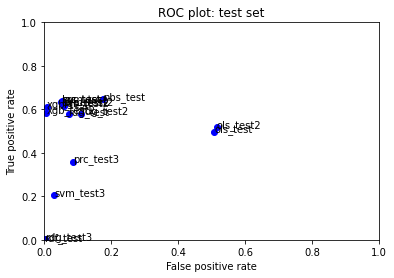

In [172]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test, 
       ols_performance_test2, svm_performance_test2, lgs_performance_test2, prc_performance_test2, rdg_performance_test2,
        svm_performance_test3, rdg_performance_test3, prc_performance_test3,
        xgb_performance_test,  xgb_performance_test2
       ]


for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### F1-Score to compare performance of various models

F1 score is a metric to measure the model performance combined with both precision and recall. The formula is  $f1{score} = 2* \frac{precision * recall}{precision + recall}$. The range of f1 score is [0, 1], so we can use it to replace the accuracy as a metric.

In [173]:
# define f1
def f1(performance_measures):
    return 2 * performance_measures.performance_measures["Precision"] * performance_measures.performance_measures["Recall"] / (performance_measures.performance_measures["Precision"] + performance_measures.performance_measures["Recall"])


fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test, 
       ols_performance_test2, svm_performance_test2, lgs_performance_test2, prc_performance_test2, rdg_performance_test2, 
        svm_performance_test3, rdg_performance_test3, prc_performance_test3,
        xgb_performance_test,  xgb_performance_test2
       ]
for fit in fits:
    print(fit.desc, ":", f1(fit))

ols_test : 0.16611740473738415
svm_test : 0.6010832967354707
lgs_test : 0.6045016077170418
nbs_test : 0.40424096385542163
prc_test : 0.6080781180648025
rdg_test : 0.5201444845790497
rdf_test : nan
ols_test2 : 0.1705237515225335
svm_test2 : 0.588595595741578
lgs_test2 : 0.5783760312635693
prc_test2 : 0.5876860227604319
rdg_test2 : 0.4543478260869565
svm_test3 : 0.28012486992715924
rdg_test3 : 0.00479472580161822
prc_test3 : 0.3397094779231986
xgb_test : 0.7323372071573511
xgb_test2 : 0.7126739375705152


### looking at reviews based on their classification

Let's say we decide that Xgboost is the best model on test set. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it is.

### let's look at some false positives:

In [174]:
xgb_predictions = xgb2.predict(X_test)

In [175]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(xgb_predictions)):
    if (xgb_predictions[i] == 1):
        if (X_raw_test.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_test.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
58
It was signed Moron - what part of that didn't you understand...
* * * * * * * * * 
780
"BTW The Adversary on the wikipediareview website has  reputation for being extremely nasty and unpleasant about other wikipedians. Now Huldra has revealed this to be her, are you certain Huldra is exactly the sweet loving person she is to you. I have created a great deal really good content on here and this is how she and her moron wasters regard me. White cat  

"
* * * * * * * * * 
5178
"

 TMI / Randall Thompson 
Hm, are you saying that your claims regarding his claims are more reputable due to your mentioning of him mentioning conspiracy?  I'd challenge your sanity if that would be the case, of course hoping it is not.  Many real stories sound unbelievable, and lots of crap is thoroughly ""sourced"" to fool people.  It takes close attention to even small discrepancies to tell reality apart from crap at times.  Good luck.   "
* * * * * * * * * 
5742
Well, my mothe

# Iteration 5 -- tune parameters

After applying the most powerful tools, I consider using cross-validation to tune the parameters of xgboost to achieve the best performance. Since the model training will cost a lot, we just use 2-folder to select the best results.

In [176]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_validate, validation_curve

# only return the preprocessing data before train_test_split
def words_processing_cv(fn, my_random_seed):
    # read data
    toxic_data = pd.read_csv(fn)
    
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
    toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    
    print("The rate of 'toxic' Wikipedia comments in the dataset: ")
    print(toxic_data['any_toxic'].mean())

    # lowcasing
    toxic_data.comment_text = toxic_data.comment_text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    print("lowcasing complete")
    
    # remove punctuaton
    toxic_data.comment_text = toxic_data.comment_text.str.replace("[^\w\s]", "")
    print("punctuation removal complete")
    
    # remove stopwords
    stop = stopwords.words("english")
    toxic_data.comment_text = toxic_data.comment_text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    print("stopwords removal complete")
    
    # remove common words
    word_freq = list(pd.Series(" ".join(toxic_data.comment_text).split()).value_counts()[:20].index)
    toxic_data.comment_text = toxic_data.comment_text.apply(lambda x: " ".join(x for x in x.split() if x not in word_freq))
    print("common words removal complete")

    
   
    hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
    X_hv = hv.fit_transform(toxic_data.comment_text)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['myfeature'] =  toxic_data['comment_text'].str.split(' ').str.len() * toxic_data['comment_text'].str.count("\.");
    X_quant_features = toxic_data[["word_count", "punc_count","myfeature"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    y = toxic_data['any_toxic']
        
        
        
        
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    
    print("Shape of X_train and X_test:")
    print(X_train.shape)
    print(X_test.shape)
    print("Shape of y_train and y_test:")
    print(y_train.shape)
    print(y_test.shape)
    print("Shape of X_raw_train and X_raw_test:")
    print(X_raw_train.shape)
    print(X_raw_test.shape)
    print('SUCCESS!')
    return(X, y)
    

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X,y = words_processing_cv(fn='toxiccomments_train.csv', my_random_seed=100)

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

In [177]:
# cv check result
cv = KFold(n_splits=5, shuffle=True, random_state=12345)
print('test_score:', cross_val_score(xgb2, X, y, cv=cv, scoring='f1'))

test_score: [0.71213829 0.71342383 0.69966254 0.7192846  0.71689077]


In [178]:
# grid search
parameters = {
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.1]
}



gsearch = GridSearchCV(xgb2, param_grid=parameters, scoring='f1', cv=2)
gsearch.fit(X, y)
print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.663
Best parameters set:
	learning_rate: 0.1
	max_depth: 10


# Final Model -- Xgboost

In [179]:
xgb = XGBClassifier(**{"learning_rate":0.1, "max_depth":10})
xgb.fit(X_train, y_train)
data_process_method = process_raw_data

## Why we do not choose the data_process_method as the method in iteration 2? 
##### In iteration 2, we do some data cleaning: lowcasing, common words removal, but the result shows poorer performance than the original one. This is because some toxic text is spelled by upper case and wrote in inofficial way. These non-normal patterns will become features to identify them. This is the reason why data cleaning shows negative results to the classification in toxic text.

---

# <span style="color:red">SUBMISSION</span>

---

In [180]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = data_process_method(fn='toxiccomments_test.csv', my_random_seed=12345, test=True)
print("Number of rows in the submission test set (should be 153,164): ", X_test_submission.shape[0])

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  myfeature
0          72          10        720
1          13           1         13
2          16           0          0
3          38           3        114
4           7           1          7
5     

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the xgboost model fit, which is in the `xgb` object. But you should choose the model that is performing the best for you! 

In [181]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = xgb.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.15019195111122718


In [182]:
raw_data.head()

,id,comment_text,word_count,punc_count,myfeature
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,720
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,13
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,114
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,7


In [183]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [184]:
my_submission.shape

(153164, 2)

In [185]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation